In [1]:
import os
import json
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
# install Kaggle
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chaimabouab","key":"4c9dba2231ee394879b8af8eafc26cdc"}'}

In [4]:
#Creat a kaggle folder
!mkdir ~/.kaggle

In [5]:
#copy the kaggle.json to folder created
!cp kaggle.json  ~/.kaggle/

In [6]:
#permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-dataset

... resuming from 531628032 bytes (24239587708 bytes left) ...
100% 23.0G/23.1G [03:52<00:00, 99.6MB/s]
100% 23.1G/23.1G [03:52<00:00, 104MB/s] 


In [ ]:
!unzip fashion-product-images-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: fashion-dataset/images/30771.jpg  
  inflating: fashion-dataset/images/30772.jpg  
  inflating: fashion-dataset/images/30773.jpg  
  inflating: fashion-dataset/images/30774.jpg  
  inflating: fashion-dataset/images/30775.jpg  
  inflating: fashion-dataset/images/30776.jpg  
  inflating: fashion-dataset/images/30777.jpg  
  inflating: fashion-dataset/images/30778.jpg  
  inflating: fashion-dataset/images/30779.jpg  
  inflating: fashion-dataset/images/3078.jpg  
  inflating: fashion-dataset/images/30780.jpg  
  inflating: fashion-dataset/images/30781.jpg  
  inflating: fashion-dataset/images/30782.jpg  
  inflating: fashion-dataset/images/30783.jpg  
  inflating: fashion-dataset/images/30784.jpg  
  inflating: fashion-dataset/images/30785.jpg  
  inflating: fashion-dataset/images/30786.jpg  
  inflating: fashion-dataset/images/30787.jpg  
  inflating: fashion-dataset/images/30788.jpg  
  inflating: fashion-dataset/images/30

In [12]:
!pip install keras-tuner
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00


In [17]:
#ignore warnings
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

import tensorflow as tf
# data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# wandb
import wandb
from wandb.keras import WandbCallback

#DATA_PATH = './fashion-dataset'
DATA_PATH = './'
%matplotlib inline

In [18]:
images_df = pd.read_csv(
  os.path.join(DATA_PATH, 'fashion-dataset', 'images.csv')
  )

In [19]:
images_df.head(2)

,filename,link
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...


In [20]:
styles_df = pd.read_csv(
    os.path.join(DATA_PATH, 'fashion-dataset', 'styles.csv'),
    on_bad_lines='skip'
)

In [21]:
styles_df.head(2)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans


In [22]:
images_df.head(2)

,filename,link
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...


In [23]:
images_df['id'] = images_df['filename']\
.apply(lambda filename: filename\
       .replace('.jpg', '')).astype(int)

In [24]:
images_df.head(2)

,filename,link,id
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...,15970
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...,39386


In [25]:
data = styles_df.merge(images_df, on='id', how='left')
data.head(2)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg,http://assets.myntassets.com/v1/images/style/p...


In [26]:
# chuyển filename thành filepath
data['filename'] = data['filename']\
.apply(lambda filename: os.path.join(DATA_PATH, 'fashion-dataset', 'images', filename))
data.head(2)

TypeError: join() argument must be str, bytes, or os.PathLike object, not 'float'

In [20]:
# lấy danh sách ảnh trong dataset
image_files = os.listdir(
    os.path.join(DATA_PATH, 'fashion-dataset', 'images')
)
print(len(image_files))

44441


In [21]:
# các file có trong dataset
data['file_found'] = data['id'].apply(lambda idx: '{}.jpg'.format(idx)  in image_files)

In [22]:
data['file_found'].value_counts()

True     44419
False        5
Name: file_found, dtype: int64

In [23]:
# xóa bỏ file không có ảnh trong dataset
data = data[data['file_found']].reset_index(drop=True)
print(data.shape)
data.head(2)

(44419, 13)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link,file_found
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,./fashion-dataset/fashion-dataset/images/15970...,http://assets.myntassets.com/v1/images/style/p...,True
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,./fashion-dataset/fashion-dataset/images/39386...,http://assets.myntassets.com/v1/images/style/p...,True


In [24]:
data.isnull().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
filename                0
link                    0
file_found              0
dtype: int64

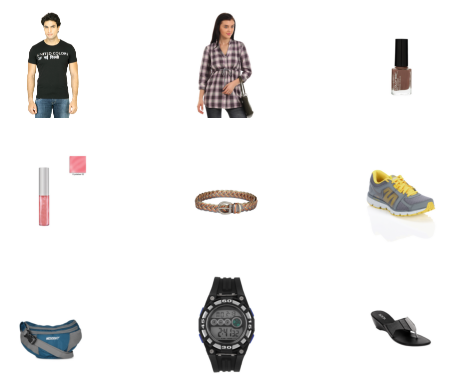

In [25]:
# trực quan một số hình ảnh trong datasets
def dislay_image(image_files):
    random.shuffle(image_files)
    for idx, image_file in enumerate(image_files[0:9]):
        plt.subplot(3, 3, idx+1)
        image_path = os.path.join(DATA_PATH, 'fashion-dataset', 'images', image_file)
        image_arr = cv2.imread(image_path)
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB)

        plt.imshow(image_arr)
        plt.axis("off")

dislay_image(image_files)

In [26]:
# masterCategory count
gr_data_masterCate = data.groupby('masterCategory').size()
gr_data_masterCate_sorted= gr_data_masterCate.sort_values()
gr_data_masterCate_sorted

masterCategory
Home                  1
Sporting Goods       25
Free Items          105
Personal Care      2403
Footwear           9219
Accessories       11274
Apparel           21392
dtype: int64

In [27]:
# subCategory count
gr_data_subCate = data.groupby('subCategory').size()
gr_data_subCate_sorted= gr_data_subCate.sort_values()

In [28]:
len(gr_data_subCate_sorted)

45

In [29]:
# articleType count
gr_data_articleType = data.groupby('articleType').size()
gr_data_articleType_sorted = gr_data_articleType.sort_values()

In [30]:
categoricals = sorted(list(gr_data_subCate_sorted.index[-20:]))

In [31]:
data_20 = data[data['subCategory'].isin(categoricals)]

In [32]:
data_20 = data_20[['subCategory', 'filename']]

In [33]:
data_20

,subCategory,filename
0,Topwear,./fashion-dataset/fashion-dataset/images/15970...
1,Bottomwear,./fashion-dataset/fashion-dataset/images/39386...
2,Watches,./fashion-dataset/fashion-dataset/images/59263...
3,Bottomwear,./fashion-dataset/fashion-dataset/images/21379...
4,Topwear,./fashion-dataset/fashion-dataset/images/53759...
...,...,...
44414,Shoes,./fashion-dataset/fashion-dataset/images/17036...
44415,Flip Flops,./fashion-dataset/fashion-dataset/images/6461.jpg
44416,Topwear,./fashion-dataset/fashion-dataset/images/18842...
44417,Fragrance,./fashion-dataset/fashion-dataset/images/46694...


In [34]:
data_20.groupby('subCategory').size().sort_values(ascending=False)

subCategory
Topwear                     15398
Shoes                        7343
Bags                         3055
Bottomwear                   2693
Watches                      2542
Innerwear                    1808
Jewellery                    1079
Eyewear                      1073
Fragrance                    1011
Sandal                        963
Wallets                       933
Flip Flops                    913
Belts                         811
Socks                         698
Lips                          527
Dress                         478
Loungewear and Nightwear      470
Saree                         427
Nails                         329
Makeup                        307
dtype: int64

In [35]:
from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split

In [36]:
n_samples = 600
lst_df = []
for categorical in categoricals:
    df_class_tmp = data_20.loc[data_20['subCategory'] == categorical]
    if df_class_tmp.shape[0] < n_samples:
        df_resample_tmp = df_class_tmp
    else:
        df_resample_tmp = resample(df_class_tmp, n_samples=n_samples, random_state=42)
    lst_df.append(df_resample_tmp)
df = pd.concat(lst_df)

In [37]:
df.shape

(10938, 2)

In [38]:
df = shuffle(df, random_state=42)
df = df.reset_index(drop=True)

In [39]:
df.rename({'subCategory':'categorical'}, axis=1, inplace=True)

In [40]:
# final data
data = df
data

,categorical,filename
0,Bags,./fashion-dataset/fashion-dataset/images/4596.jpg
1,Makeup,./fashion-dataset/fashion-dataset/images/56581...
2,Lips,./fashion-dataset/fashion-dataset/images/55488...
3,Fragrance,./fashion-dataset/fashion-dataset/images/45693...
4,Dress,./fashion-dataset/fashion-dataset/images/57052...
...,...,...
10933,Lips,./fashion-dataset/fashion-dataset/images/55028...
10934,Jewellery,./fashion-dataset/fashion-dataset/images/52328...
10935,Lips,./fashion-dataset/fashion-dataset/images/55978...
10936,Belts,./fashion-dataset/fashion-dataset/images/25753...


In [41]:
from sklearn.model_selection import train_test_split

In [42]:
train_df, test_df = train_test_split(data,\
                                     test_size=0.2,\
                                     random_state=42,\
                                     stratify=data['categorical'])
valid_df, test_df = train_test_split(test_df,\
                                      test_size=0.5,\
                                      random_state=42,\
                                      stratify=test_df['categorical'])

In [43]:
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [44]:
train_df

,categorical,filename
0,Fragrance,./fashion-dataset/fashion-dataset/images/58959...
1,Belts,./fashion-dataset/fashion-dataset/images/12453...
2,Sandal,./fashion-dataset/fashion-dataset/images/7969.jpg
3,Bags,./fashion-dataset/fashion-dataset/images/53369...
4,Shoes,./fashion-dataset/fashion-dataset/images/4993.jpg
...,...,...
8745,Innerwear,./fashion-dataset/fashion-dataset/images/59080...
8746,Dress,./fashion-dataset/fashion-dataset/images/34578...
8747,Nails,./fashion-dataset/fashion-dataset/images/55868...
8748,Fragrance,./fashion-dataset/fashion-dataset/images/26733...


In [64]:
datagen = ImageDataGenerator(rescale=1/255.,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True)

train_generator = datagen.flow_from_dataframe(dataframe=train_df,
                                             target_size=(224,224),
                                             x_col='filename',
                                            y_col='categorical',
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=True,
                                              seed=42)


test_datagen = ImageDataGenerator(rescale=1/255.)
valid_generator = test_datagen.flow_from_dataframe(dataframe=valid_df,
                                             target_size=(224,224),
                                             x_col='filename',
                                            y_col='categorical',
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=True,
                                              seed=42)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='categorical',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 8750 validated image filenames belonging to 20 classes.
Found 1094 validated image filenames belonging to 20 classes.
Found 1094 validated image filenames belonging to 20 classes.


In [46]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [55]:
def build_model(name, weights_path=None):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(4096, activation='leaky_relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation='sigmoid')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    predictions = Dense(20, activation='softmax')(x)

    model = Model(name=name, inputs=base_model.input, outputs=predictions)
    #if weights_path:
      #  model.load_weights(weights_path)
    return model

In [48]:
import time

In [ ]:
NAME = "InceptionV3-{}".format(int(time.time()))
model = build_model(NAME)
model.summary()

In [57]:
lr = 0.01
epochs = 10

In [58]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr),
              metrics=['accuracy'])

In [ ]:

#callbacks = [wandb.keras.WandbCallback()]

history = model.fit_generator(train_generator,
                    validation_data = valid_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=epochs,

                    )

In [65]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Charger l'architecture InceptionV3 sans les couches fully connected
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Créer un modèle séquentiel et ajouter l'architecture InceptionV3
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(20, activation='softmax'))

# Compiler le modèle avec SGD comme optimiseur et un taux d'apprentissage de 0.01
model.compile(optimizer=SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle à partir de zéro
history_InceptionV3 =model.fit(train_generator, epochs=10, batch_size=64, validation_data=valid_generator, callbacks=[reduce_lr, early_stop])

#history_InceptionV3 = model.fit(train_generator,epochs=10, batch_size=24, validation_data=valid_generator)

Epoch 1/10
  8/274 [..............................] - ETA: 1:13:37 - loss: 5.4617 - accuracy: 0.2461

KeyboardInterrupt: 

In [ ]:
model.save('Inceptionv3_model.h5')

In [ ]:
# Plot losses
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# Plot MSE
plt.plot(history.history['accuracy'], label="train mse")
plt.plot(history.history[ 'val_accuracy'], label="test mse")
plt.legend()
plt.show()

In [ ]:
score = model.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model(filepath)

In [ ]:
score = best_model.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])